## Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

## Data Understanding

Dataset yang digunakan adalah *Pima Indians Diabetes Database* dari Kaggle. Dataset ini berisi data medis wanita keturunan Indian Pima berusia di atas 21 tahun, dan digunakan untuk mendeteksi kemungkinan diabetes.

Sumber data: (https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

Jumlah data: 768 baris, 9 kolom (8 fitur + 1 target).

In [3]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

#### Cek Outlier (IQR)

In [7]:
Q1 = df['Insulin'].quantile(0.25)
Q3 = df['Insulin'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Insulin'] < (Q1 - 1.5 * IQR)) | (df['Insulin'] > (Q3 + 1.5 * IQR))]
print(f"Jumlah outlier pada kolom Insulin: {len(outliers)}")

Jumlah outlier pada kolom Insulin: 34


#### Cek Duplikasi

In [8]:
df.duplicated().sum()

0

## Data Preparation

Tahapan preprocessing data yang dilakukan antara lain:
- Mengganti nilai nol pada kolom medis tertentu yang tidak masuk akal dengan NaN
- Mengisi nilai kosong dengan median
- Standarisasi fitur
- Membagi data menjadi data latih dan data uji (80:20)

In [9]:
cols_with_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)

# Cek jumlah missing value
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

#### Isi Nilai Kosong

In [10]:
# Isi NaN dengan median
for col in cols_with_zero_invalid:
    df[col] = df[col].fillna(df[col].median())

# Cek kembali
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### Split Data

In [11]:
# Pisahkan fitur dan target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Cek ukuran data
X_train.shape, X_test.shape

((614, 8), (154, 8))

#### Standarisasi

In [12]:
# Inisialisasi scaler
scaler = StandardScaler()

# Fit dan transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelling

Dua model yang digunakan untuk prediksi diabetes:
- Logistic Regression
- Random Forest Classifier

Model akan dilatih menggunakan data latih dan dievaluasi pada data uji.

In [13]:
# Inisialisasi model
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)

#### Latih Model

In [14]:
# Latih model Logistic Regression
logreg.fit(X_train_scaled, y_train)

# Latih model Random Forest
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

## Evaluation

Evaluasi dilakukan dengan menggunakan metrik:
- Akurasi
- Precision
- Recall
- F1-Score
- Confusion Matrix

In [15]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print classification report
    print(f"=== {model_name} ===")
    print(f"Accuracy : {acc}")
    print(f"Precision: {prec}")
    print(f"Recall   : {rec}")
    print(f"F1 Score : {f1}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot metric bar chart
    metrics = [acc, prec, rec, f1]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(8, 4))
    sns.barplot(x=metric_names, y=metrics, palette="viridis")
    plt.ylim(0, 1)
    plt.title(f"Model Metrics - {model_name}")
    for i, v in enumerate(metrics):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.show()

=== Logistic Regression ===
Accuracy : 0.7077922077922078
Precision: 0.6
Recall   : 0.5
F1 Score : 0.5454545454545454

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



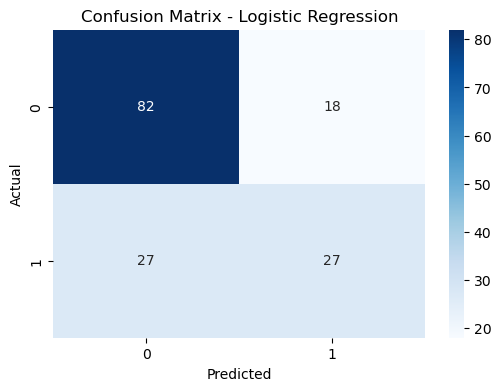

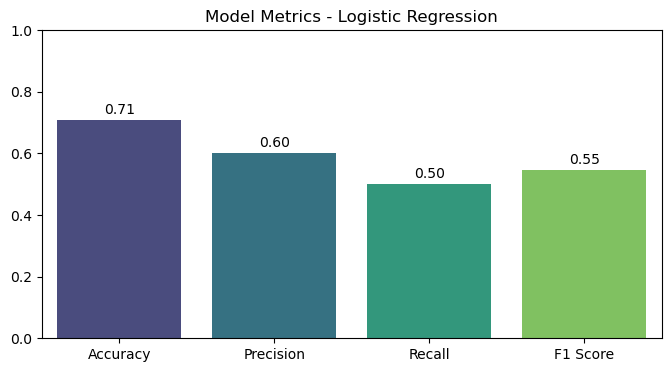

=== Random Forest Classifier ===
Accuracy : 0.7792207792207793
Precision: 0.717391304347826
Recall   : 0.6111111111111112
F1 Score : 0.6599999999999999

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.72      0.61      0.66        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



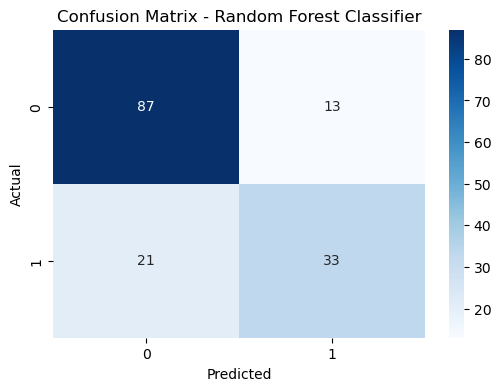

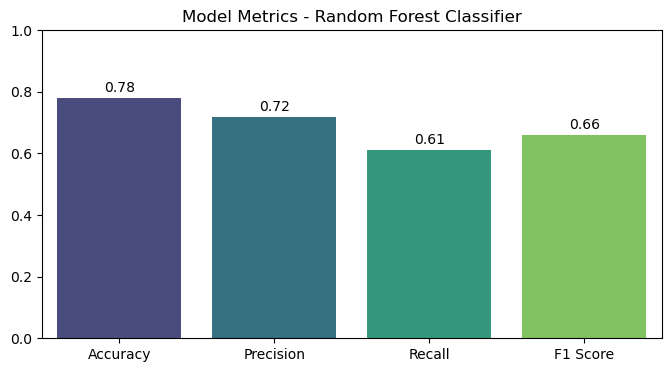

In [16]:
evaluate_model(logreg, X_test_scaled, y_test, "Logistic Regression")
evaluate_model(rf, X_test_scaled, y_test, "Random Forest Classifier")

## Inference

In [17]:
import numpy as np

sample_data = np.array([[5, 116, 74, 0, 0, 25.6, 0.201, 30]])
sample_data_scaled = scaler.transform(sample_data)

# Prediksi
predicted_class = rf.predict(sample_data_scaled)
print("Prediksi (0 = tidak diabetes, 1 = diabetes):", predicted_class[0])

Prediksi (0 = tidak diabetes, 1 = diabetes): 0


C:\Users\Nalendra Marchelo\Anaconda Navi\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
import gradio as gr

def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age):
    input_data = [[Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age]]
    prediction = rf.predict(scaler.transform(input_data))
    return "🔴 Diabetes" if prediction[0] == 1 else "🟢 Tidak Diabetes"

interface = gr.Interface(
    fn=predict_diabetes,
    inputs=[
        gr.Number(label="Pregnancies", info="Jumlah kehamilan", precision=0),
        gr.Number(label="Glucose", info="Kadar glukosa (mg/dL)", precision=1, minimum=0, maximum=200),
        gr.Number(label="Blood Pressure", info="Tekanan darah (mm Hg)", precision=1, minimum=0, maximum=150),
        gr.Number(label="Skin Thickness", info="Ketebalan kulit (mm)", precision=1, minimum=0, maximum=100),
        gr.Number(label="Insulin", info="Kadar insulin (mu U/ml)", precision=1, minimum=0, maximum=900),
        gr.Number(label="BMI", info="Body Mass Index", precision=2, minimum=0, maximum=70),
        gr.Number(label="Diabetes Pedigree Function", info="Skor riwayat keluarga", precision=3, minimum=0.0, maximum=3.0),
        gr.Number(label="Age", info="Usia (tahun)", precision=0, minimum=10, maximum=100)
    ],
    outputs=gr.Textbox(label="Hasil Prediksi"),
    title="Prediksi Diabetes",
    description="Masukkan parameter medis di bawah ini untuk memprediksi kemungkinan diabetes berdasarkan model Random Forest.",
    theme="soft"
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
